# QooQit user journey tutorial

1. Embedders
2. Creating a QuantumProgram
3. Compiling to a device
4. Executing a QuantumProgram

GitHub: https://github.com/pasqal-io/qoolqit

Docs: https://pasqal-io.github.io/qoolqit or https://docs.pasqal.com/qoolqit

## 1. Embedders
Anything that help us to map an abstract problem into something that can be implemented in Pasqal's hardware

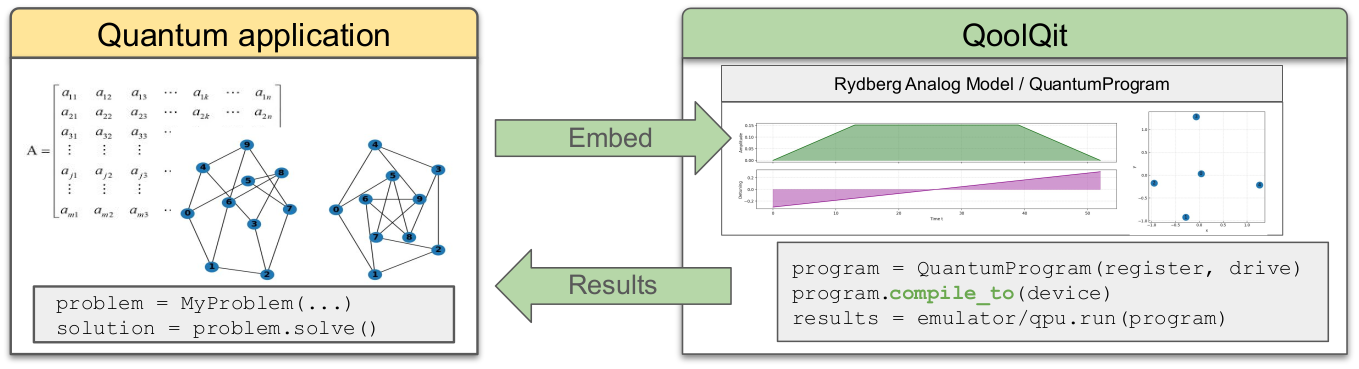

Two available **graph** embedders:
- graph to graph embedder
- matrix to graph embedder

More to come in collaboration with application developers.

Info at https://pasqal-io.github.io/qoolqit/latest/contents/available_embedders/

### a. **Graph->Graph:** SpringLayout Embedder

Embed a generic graph into one with well-defined coordinates positions.

In [6]:
from qoolqit import SpringLayoutEmbedder

sl_embedder = SpringLayoutEmbedder()
print(sl_embedder)

SpringLayoutEmbedder:
| Algorithm: spring_layout_embedding
| Config: SpringLayoutConfig(k=None, iterations=50, threshold=0.0001, seed=None)


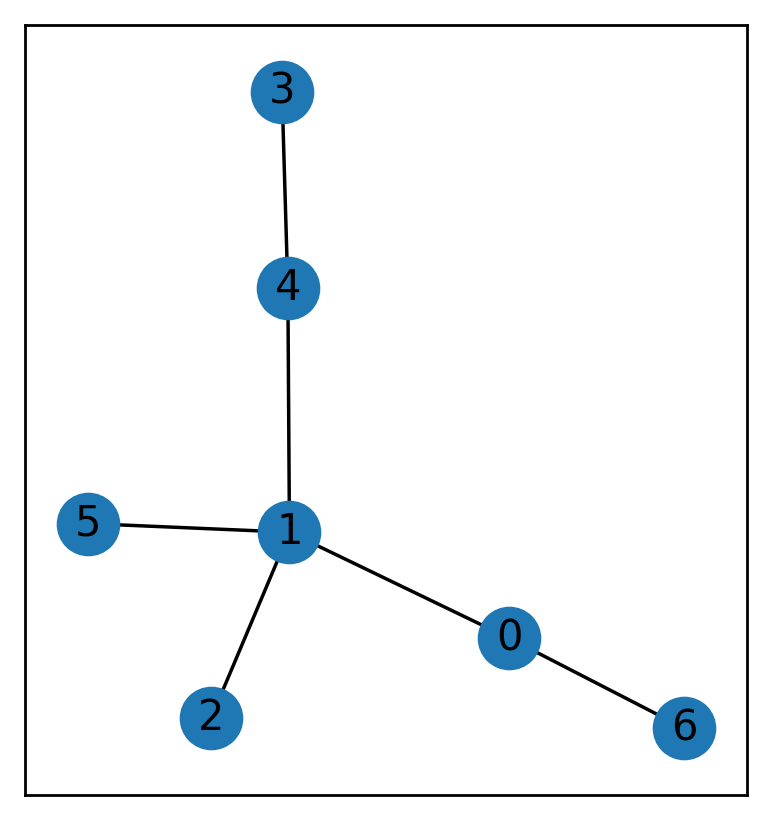

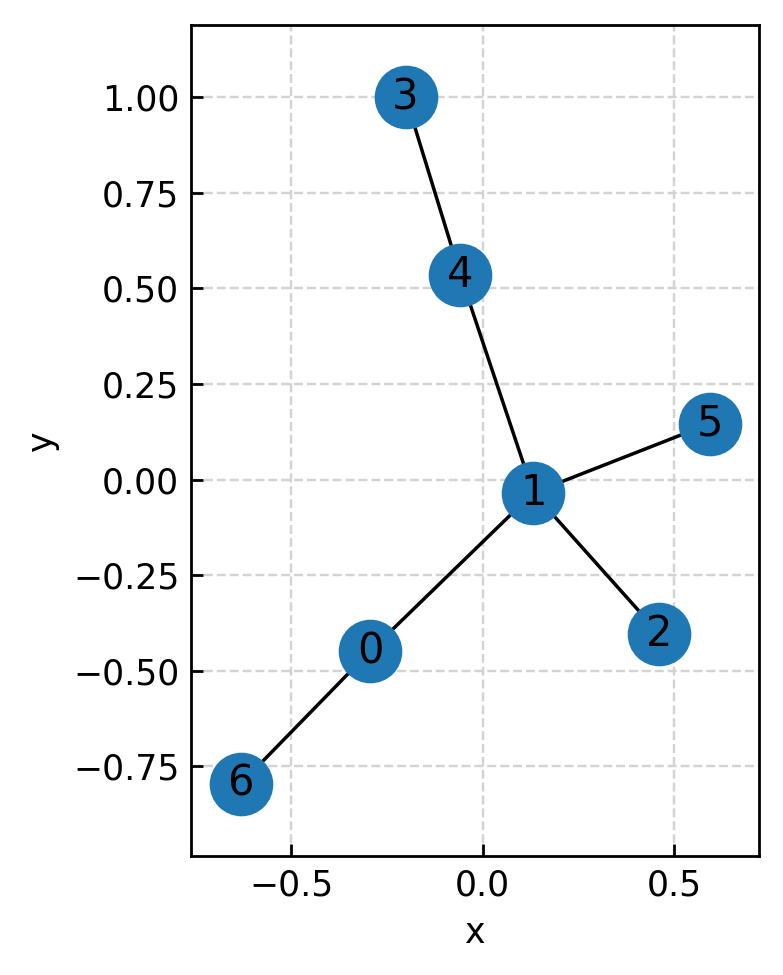

In [7]:
from qoolqit import DataGraph

# start with a graph with no coordinates
graph_1 = DataGraph.random_er(n = 7, p = 0.3, seed = 3)

# embed with spring-layout, assigning coordinates
embedded_graph_1 = sl_embedder.embed(graph_1)

graph_1.draw()
embedded_graph_1.draw()

### b. **Matrix->Graph:** Interaction embedder
Matrix to graph embedders try to embed the off-diagonal elements of a matrix (representing an instance of a QUBO problem for example), into interactions between qubits in the Rydberg Analog Model.

In [8]:
import numpy as np

Q = np.array([
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
])
Q = Q/Q.max()

InteractionEmbedder:
| Algorithm: interaction_embedding
| Config: InteractionEmbeddingConfig(method='Nelder-Mead', maxiter=200000, tol=1e-08)


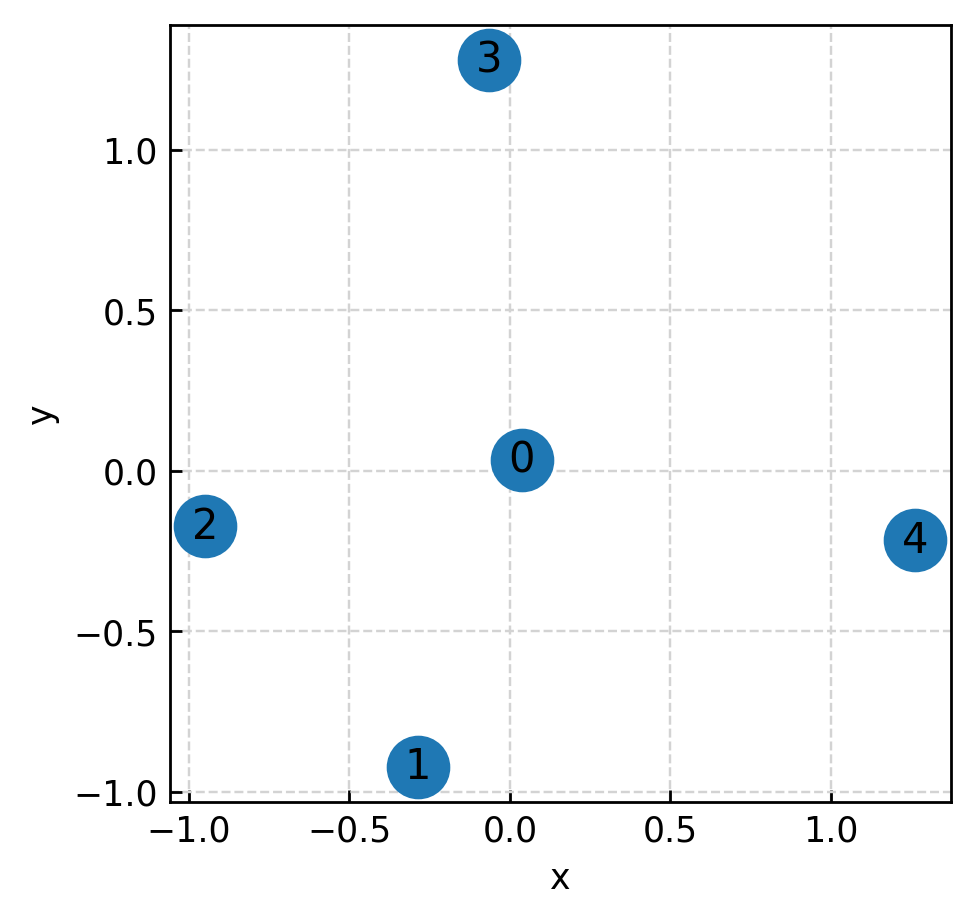

In [9]:
from qoolqit import InteractionEmbedder

embedder = InteractionEmbedder()
print(embedder)

embedded_graph = embedder.embed(Q)
embedded_graph.draw()

# 2. Creating a QuantumProgram

After the embedding stage, creating a QuantumProgram is similar to Pulser workflow.

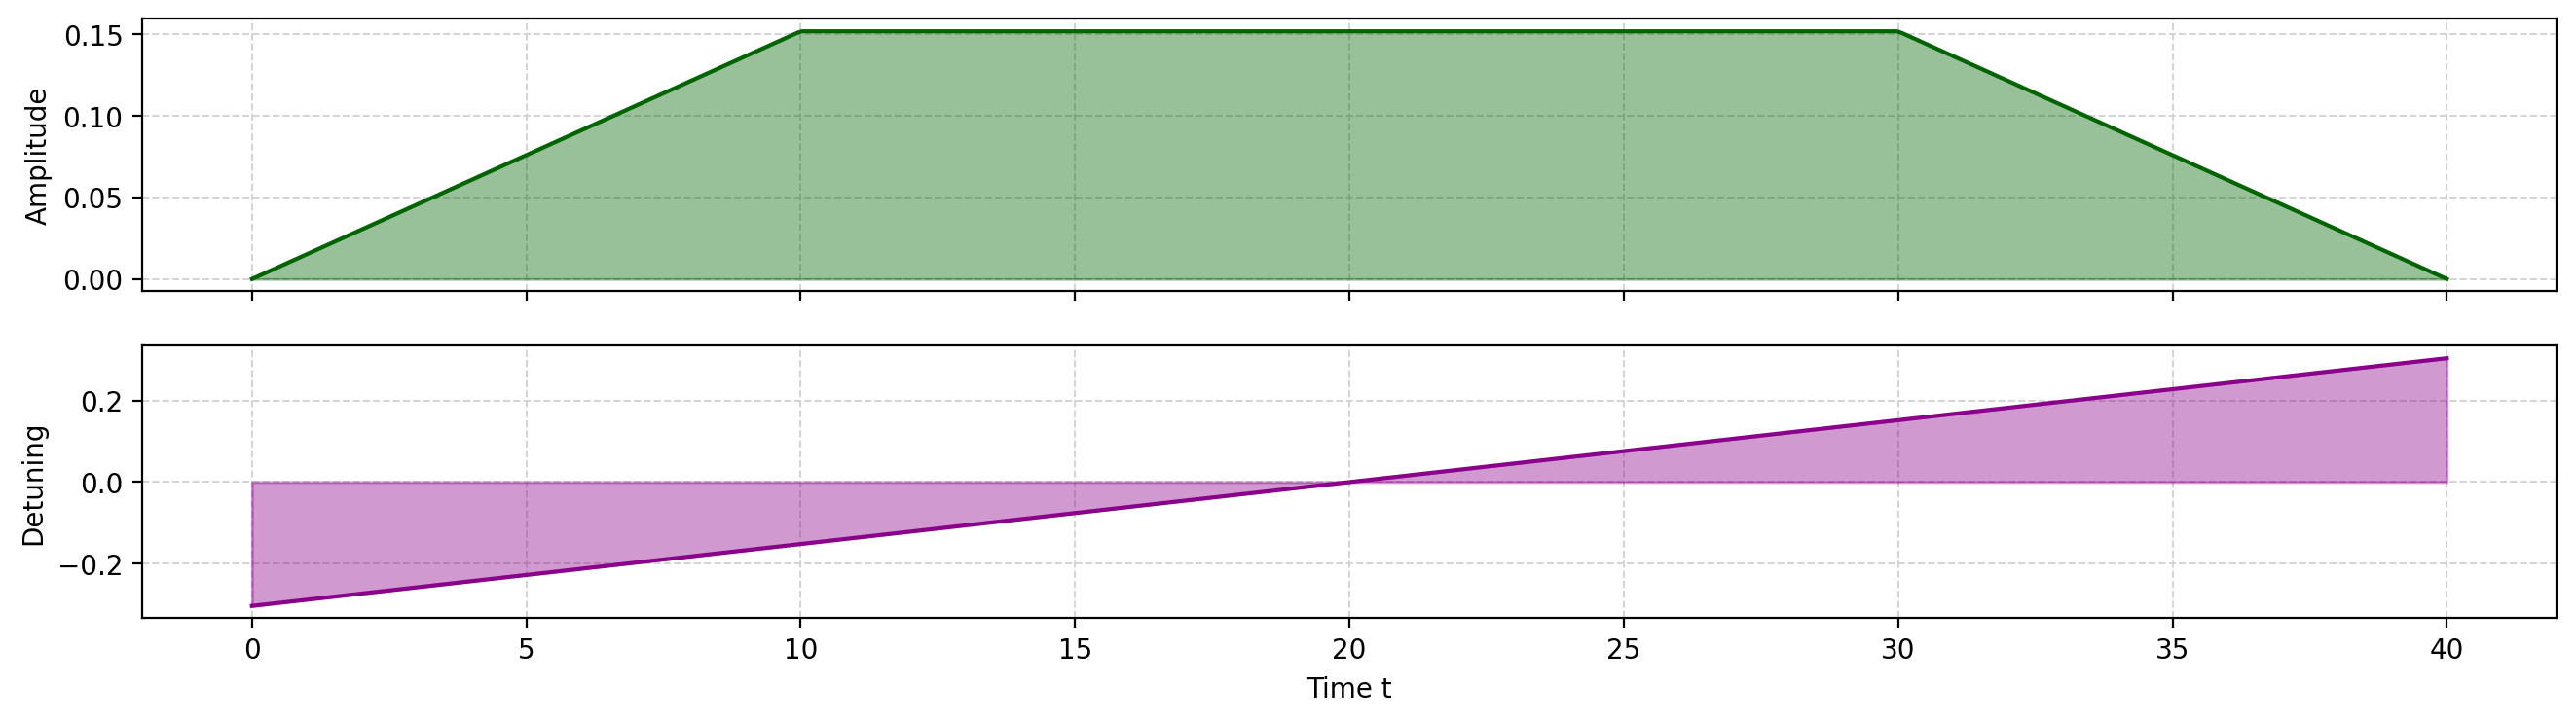

In [10]:
from qoolqit import Drive, PiecewiseLinear, QuantumProgram, Ramp, Register

# Create the register
register = Register.from_graph(embedded_graph)

# Defining the drive
omega = np.median(Q[Q > 0].flatten())
delta_i = -2.0 * omega
delta_f = 2.0 * omega
T = 40.0

amplitude = PiecewiseLinear([T/4, T/2, T/4], [0.0, omega, omega, 0.0])
detuning = Ramp(T, delta_i, delta_f)
drive = Drive(amplitude = amplitude, detuning = detuning)

# Writing the quantum program
program = QuantumProgram(register, drive)
program.draw()

# 3. Compiling to a device
- The `QuantumProgram` is hardware-agnostic so far.
- A program **must** be compiled before being executed.

In [11]:
from qoolqit import AnalogDevice

device = AnalogDevice()
program.compile_to(device=device)
#program.compile_to(device=device, profile=CompilerProfile.MAX_DURATION)

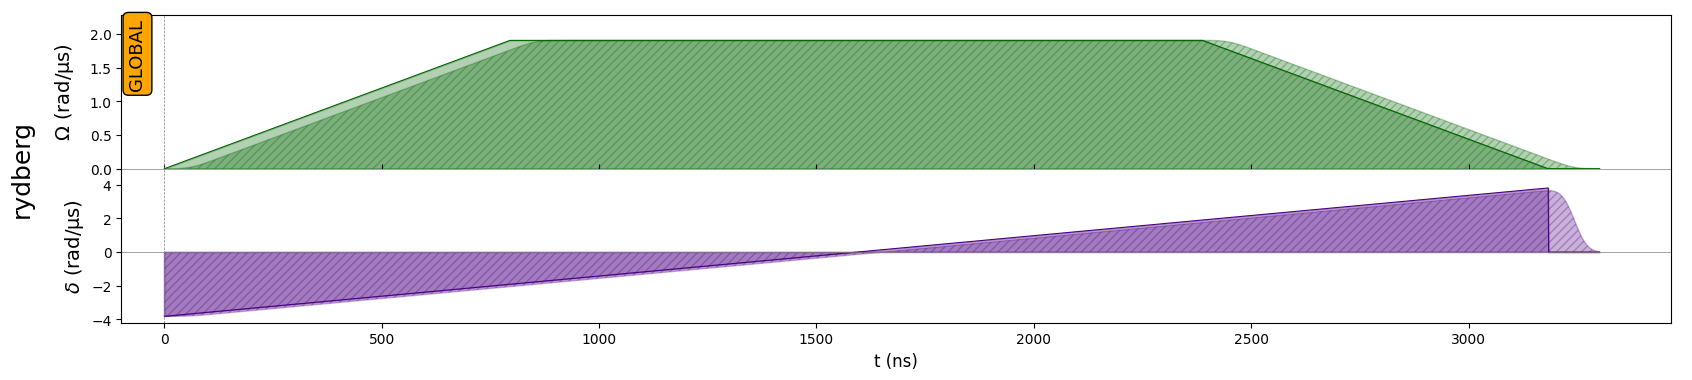

In [12]:
# view the compiled Pulser sequence
program.compiled_sequence.draw()

## 4. Execution
Execution has to cover use-cases from **beginner** to **advanced** 

- Local/remote emulators, QPU
- More info at https://pasqal-io.github.io/qoolqit/latest/contents/execution/

In [13]:
from qoolqit import LocalEmulator

emulator = LocalEmulator()
results = emulator.run(program)

## Show results
- Same Results object as in Pulser
- TODO: convenient post-processing methods

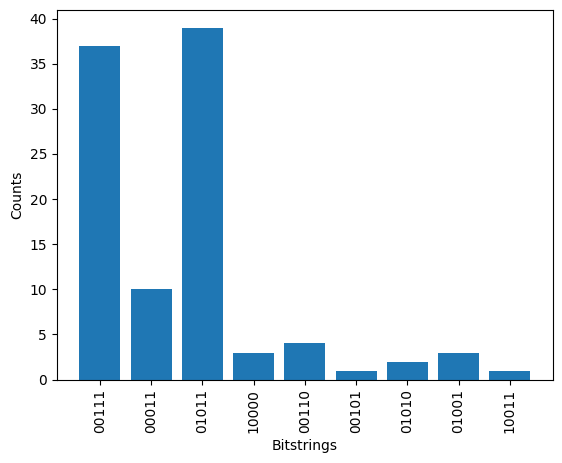

In [14]:
import matplotlib.pyplot as plt


def plot_distribution(counter):
    fig, ax = plt.subplots()
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.bar(range(len(counter)), counter.values(), tick_label=counter.keys())
    ax.tick_params("x", rotation=90)
    return fig

fig = plot_distribution(results[0].final_bitstrings)

### a. Configure your emulator
A more complex use-case is, for example, configuring a remote backend.
More info at https://pasqal-io.github.io/qoolqit/latest/contents/execution/

Remote execution requires a connection object to connect to Pasqal Cloud services:

In [15]:
import os  # store credentials as env variables

from pulser_pasqal import PasqalCloud

connection = PasqalCloud(
        username=os.getenv("PCP_USER"), 
        password=os.getenv("PCP_PASSWORD"), 
        project_id=os.getenv("PCP_PROJECT_ID")
        )

Advanced users might want to fully configure an emulator backend to exploit all its possibilities:
- defining observables to measure
- emulate real hardware-modulation effects

In [16]:
from pulser.backend import Occupation

from qoolqit import EmulationConfig, EmuMPSBackend, RemoteEmulator

observables = (Occupation(),)
emulation_config = EmulationConfig(observables=observables, with_modulation=True)

emulator = RemoteEmulator(
    backend_type=EmuMPSBackend,
    connection=connection,
    emulation_config=emulation_config,
    runs=1000
    )

In [17]:
# results = emulator.run(program)